In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import os
 
import tensorflow as tf
import tensorflow.keras as keras
from keras.layers import Conv2D, MaxPool2D, BatchNormalization, Flatten, Dropout, Dense, Activation
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
#from tensorflow.keras.optimizers import Adam
from keras.optimizers.legacy import Adam #
from PIL import Image, ImageDraw
import visualkeras
from tifffile import imread


In [2]:
# count number of training and test images
base_dir = 'data/histopathologic-cancer-detection'
train_dir, test_dir = f'{base_dir}/train/', f'{base_dir}/test/'
ntrain, ntest = len(os.listdir(train_dir)), len(os.listdir(test_dir))
print(f'#training images = {ntrain}, #test inages={ntest}')
#training images = 220025, #test inages=57458

#training images = 220025, #test inages=57458


In [3]:
# read the training images and ground truth labels into a dataframe
train_df = pd.read_csv(f'{base_dir}/train_labels.csv')
train_df['label'] = train_df['label'].astype(str)
train_df['id'] = train_df['id'] + '.tif'
train_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


In [4]:
imread(f'{train_dir}/{train_df.id[0]}').shape

(96, 96, 3)

53703
<class 'str'>
59975
<class 'str'>
136019
<class 'str'>
168133
<class 'str'>
213646
<class 'str'>
163337
<class 'str'>
41309
<class 'str'>
91299
<class 'str'>
37523
<class 'str'>


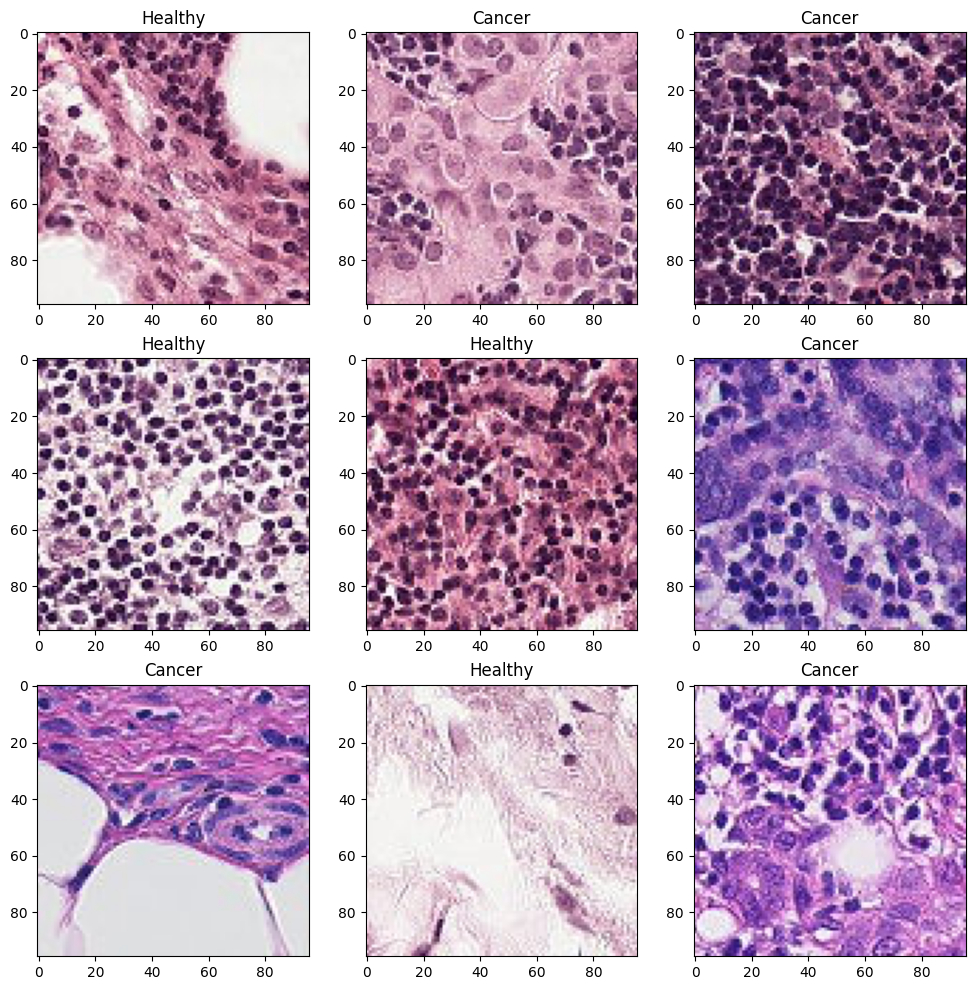

In [5]:
# Analyzing different sets
f,axes = plt.subplots(3,3)
f.set_size_inches([12,12])
axes = axes.ravel()
for i_ax, i in enumerate(np.round(np.random.sample(9)*train_df.shape[0])):
    i = int(i)
    print(i)
    im = Image.open( f'{train_dir}/{train_df.id[i]}')
    axes[i_ax].imshow(im)
    print(type(train_df.label[i]))
    if train_df.label[i] == '1':
        axes[i_ax].set_title('Cancer')
    else:
        axes[i_ax].set_title('Healthy')
        


In [8]:
batch_size, im_size = 256, (64,64)

generator = ImageDataGenerator(rescale=1./255, validation_split=0.25)

train_data = generator.flow_from_dataframe(
    dataframe = train_df,
    x_col='id', # filenames
    y_col='label', # labels
    directory=train_dir,
    subset='training',
    class_mode='binary',
    batch_size=batch_size,
    target_size=im_size)
 
val_data = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='id', # filenames
    y_col='label', # labels
    directory=train_dir,
    subset="validation",
    class_mode='binary',
    batch_size=batch_size,
    target_size=im_size)
 

In [26]:
batch_size, im_size = 256, (64,64)

model2 = keras.Sequential()

model2.add( Conv2D(16, (3,3), activation='relu') )
model2.add( Conv2D(16, (3,3), activation='relu') )
model2.add(MaxPool2D(pool_size=(2,2)))

model2.add( Conv2D(32, (3,3), activation='relu') )
model2.add( Conv2D(32, (3,3), activation='relu') )
model2.add(MaxPool2D(pool_size=(2,2)))

model2.add(Flatten())
#model2.add(Dropout(.5))
model2.add(Dense(256, activation='relu'))
model2.add(Dense(1, activation='relu'))

model2.build(input_shape=(batch_size,im_size[0],im_size[1],3))
model2.summary()


opt = Adam(learning_rate=0.0001)
model2.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
hist = model2.fit(train_data, validation_data=val_data, epochs=10)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_37 (Conv2D)          (256, 62, 62, 16)         448       
                                                                 
 conv2d_38 (Conv2D)          (256, 60, 60, 16)         2320      
                                                                 
 max_pooling2d_18 (MaxPooli  (256, 30, 30, 16)         0         
 ng2D)                                                           
                                                                 
 conv2d_39 (Conv2D)          (256, 28, 28, 32)         4640      
                                                                 
 conv2d_40 (Conv2D)          (256, 26, 26, 32)         9248      
                                                                 
 max_pooling2d_19 (MaxPooli  (256, 13, 13, 32)         0         
 ng2D)                                               

In [25]:

images_test = pd.DataFrame({'id': [d for d in os.listdir(test_dir) if '.DS_store' not in d] })
generator_test = ImageDataGenerator(rescale=1./255) 
 
test_data = generator_test.flow_from_dataframe(
    dataframe = images_test,
    x_col='id', 
    directory=test_dir,
    class_mode=None,
    batch_size=1,
    target_size=im_size,
    shuffle=False)
 
# predict with the model
predictions = model2.predict(test_data, verbose=1)
predictions = predictions.squeeze()
predictions.shape
 
# create submission dataframe for kaggle submission
submission_df = pd.DataFrame()
submission_df['id'] = images_test['id'].apply(lambda x: x.split('.')[0])
submission_df['label'] = list(map(lambda x: 0 if x < 0.5 else 1, predictions))
submission_df['label'].value_counts()
submission_df.to_csv('submission2.csv', index=False)
print(submission_df.head())
 

Found 57458 validated image filenames.
57458/57458 [==============================] - 98s 2ms/step
                                         id  label
0  fd0a060ef9c30c9a83f6b4bfb568db74b099154d      1
1  1f9ee06f06d329eb7902a2e03ab3835dd0484581      1
2  19709bec800f372d0b1d085da6933dd3ef108846      1
3  7a34fc34523063f13f0617f7518a0330f6187bd3      0
4  93be720ca2b95fe2126cf2e1ed752bd759e9b0ed      0
